In [ ]:
# Install required packages (run once)
! pip install torch torchvision numpy matplotlib seaborn pandas scikit-learn tqdm

In [ ]:
! pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


## 2. Configuration

**Modify these settings to customize your experiments:**

In [ ]:

DATASET = 'CIFAR10'  
BATCH_SIZE = 128

PART1_ENABLED = True
PART1_EPOCHS = 10
PART1_MODELS = ['LeNet-5', 'AlexNet', 'VGGNet', 'ResNet-50', 'ResNet-101',
                'MobileNet', 'EfficientNet', 'InceptionV3']  # All models

PART2_ENABLED = True
PART2_EXPERIMENTS = [
    ('VGGNet', 'Adam', 10, 'BCE'),
    ('AlexNet', 'SGD', 20, 'Focal'),
    ('ResNet-50', 'Adam', 15, 'ArcFace'),
]


PART3_ENABLED = True
TSNE_SAMPLES = 2000


LEARNING_RATE = 0.001
SAVE_RESULTS = True


Configuration loaded successfully!
Dataset: CIFAR10
Batch Size: 128
Part 1: Enabled
Part 2: Enabled
Part 3: Enabled


## 3. CNN Architecture Definitions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    
class LeNet5(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(576, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# AlexNet 
class AlexNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# VGGNet 
class VGGNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(VGGNet, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M',
                                           256, 256, 256, 'M', 512, 512, 512, 'M',
                                           512, 512, 512, 'M'], input_channels)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def _make_layers(self, cfg, input_channels):
        layers = []
        in_channels = input_channels
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                          nn.BatchNorm2d(x),
                          nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# ResNet Blocks
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()    # matches spatial size matches channel depth  allows valid addition
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, input_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def extract_features(self, x):
        """Extract features before final classification layer"""
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        return out

    def forward(self, x):
        out = self.extract_features(x)
        out = self.linear(out)
        return out

def ResNet50(num_classes=10, input_channels=3):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes, input_channels)

def ResNet101(num_classes=10, input_channels=3):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes, input_channels)

# MobileNet 
class MobileNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(MobileNet, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
            
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
            )

        self.model = nn.Sequential(
            conv_bn(input_channels, 32, 1),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# EfficientNet 
class EfficientNet(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(EfficientNet, self).__init__()

        def conv_bn_act(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.SiLU(inplace=True)
            )

        def mbconv(inp, oup, stride, expand_ratio):
            hidden_dim = int(inp * expand_ratio)
            return nn.Sequential(
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(inplace=True),
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(inplace=True),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

        self.features = nn.Sequential(
            conv_bn_act(input_channels, 32, 1),
            mbconv(32, 16, 1, 1),
            mbconv(16, 24, 2, 6),
            mbconv(24, 40, 2, 6),
            mbconv(40, 80, 2, 6),
            conv_bn_act(80, 320, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(320, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# InceptionV3 
class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(True)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(True)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(True)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionV3(nn.Module):
    def __init__(self, num_classes=10, input_channels=3):
        super(InceptionV3, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.inception1 = InceptionModule(64, 64, 96, 128, 16, 32, 32)
        self.inception2 = InceptionModule(256, 128, 128, 192, 32, 96, 64)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.inception3 = InceptionModule(480, 192, 96, 208, 16, 48, 64)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.maxpool(x)
        x = self.inception3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x




✓ All CNN architectures (including MobileNet, EfficientNet and InceptionV3) defined successfully!


## 4. Loss Functions

In [ ]:
# Focal Loss 
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()


# ArcFace Loss 
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        input_norm = F.normalize(input, p=2, dim=1)
        weight_norm = F.normalize(self.weight, p=2, dim=1)
        cosine = F.linear(input_norm, weight_norm)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * np.cos(self.m) - sine * np.sin(self.m)
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return F.cross_entropy(output, label)


class ArcFaceModel(nn.Module):
    def __init__(self, base_model, num_classes, feature_dim=512):
        super(ArcFaceModel, self).__init__()
        self.base_model = base_model
        self.feature_dim = feature_dim

        if isinstance(base_model, ResNet):
            self.base_model.linear = nn.Linear(512 * 4, feature_dim)
        elif isinstance(base_model, VGGNet):
            self.base_model.classifier[-1] = nn.Linear(512, feature_dim)

        self.arcface = ArcFaceLoss(feature_dim, num_classes)

    def forward(self, x):
        features = self.base_model(x)
        return features

    def forward_with_loss(self, x, labels):
        features = self.forward(x)
        loss = self.arcface(features, labels)
        return features, loss


print("✓ Loss functions defined successfully!")

✓ Loss functions defined successfully!


## 5. Data Loading

In [ ]:
def load_dataset(dataset_name='CIFAR10', batch_size=128):
    """Load and prepare datasets"""
    if dataset_name == 'MNIST':
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                              download=True, transform=transform_train)
        testset = torchvision.datasets.MNIST(root='./data', train=False,
                                             download=True, transform=transform_test)
        num_classes = 10
        input_channels = 1

    elif dataset_name == 'FashionMNIST':
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.2860,), (0.3530,))
        ])
        trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                     download=True, transform=transform_train)
        testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                    download=True, transform=transform_test)
        num_classes = 10
        input_channels = 1

    elif dataset_name == 'CIFAR10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                              download=True, transform=transform_test)
        num_classes = 10
        input_channels = 3

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader, num_classes, input_channels


# Load the selected dataset
print(f"Loading {DATASET} dataset...")
trainloader, testloader, num_classes, input_channels = load_dataset(DATASET, BATCH_SIZE)
print(f"✓ Dataset loaded: {DATASET}")
print(f"  Classes: {num_classes}")
print(f"  Input channels: {input_channels}")
print(f"  Training batches: {len(trainloader)}")
print(f"  Test batches: {len(testloader)}")

Loading CIFAR10 dataset...


100%|██████████| 170M/170M [00:36<00:00, 4.71MB/s]


✓ Dataset loaded: CIFAR10
  Classes: 10
  Input channels: 3
  Training batches: 391
  Test batches: 79


## 6. Training and Evaluation Functions

In [ ]:
def train_model(model, trainloader, criterion, optimizer, epochs, model_name, use_arcface=False):
    """Train the model"""
    model.train()
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(trainloader, desc=f'{model_name} Epoch {epoch+1}/{epochs}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            if use_arcface:
                features, loss = model.forward_with_loss(inputs, labels)
                outputs = model.arcface.weight @ features.T
                outputs = outputs.T
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'Loss': f'{running_loss/(pbar.n+1):.3f}',
                            'Acc': f'{100.*correct/total:.2f}%'})

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

    return train_losses, train_accuracies


def evaluate_model(model, testloader, criterion, use_arcface=False):
    """Evaluate the model"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            if use_arcface:
                features = model(inputs)
                outputs = model.arcface.weight @ features.T
                outputs = outputs.T
                loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    avg_loss = test_loss / len(testloader)

    return avg_loss, accuracy


print("✓ Training and evaluation functions defined!")

✓ Training and evaluation functions defined!


In [ ]:
import time
import pandas as pd
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if PART1_ENABLED:
    print("="*70)
    print("PART 1: CNN ARCHITECTURE COMPARISON")
    print("="*70)

    model_classes = {
        'LeNet-5': LeNet5,
        'AlexNet': AlexNet,
        'VGGNet': VGGNet,
        'ResNet-50': ResNet50,
        'ResNet-101': ResNet101,
        'MobileNet': MobileNet,
        'EfficientNet': EfficientNet,
        'InceptionV3': InceptionV3,
    }

    part1_results = []

    for model_name in PART1_MODELS:
        if model_name not in model_classes:
            print(f"Warning: {model_name} not found in model_classes. Skipping...")
            continue

        print(f"\nTraining {model_name}...")

        model = model_classes[model_name](num_classes, input_channels).to(device)
        num_params = sum(p.numel() for p in model.parameters())
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


        # Train
        start_time = time.time()
        train_losses, train_accs = train_model(model, trainloader, criterion,
                                               optimizer, PART1_EPOCHS, model_name)
        training_time = time.time() - start_time

        # Evaluate
        test_loss, test_acc = evaluate_model(model, testloader, criterion)

        # Record
        part1_results.append({
            'Model': model_name,
            'Parameters': num_params,
            'Training Time (s)': training_time,
            'Final Train Acc': train_accs[-1],
            'Test Accuracy': test_acc
        })

        print(f"✓ {model_name} completed - Test Accuracy: {test_acc:.2f}%")

    # Display Summary
    part1_df = pd.DataFrame(part1_results)
    print("\n" + "="*70)
    print("PART 1 RESULTS")
    print("="*70)
    display(part1_df.sort_values('Test Accuracy', ascending=False))

    if SAVE_RESULTS:
        part1_df.to_csv('part1_results.csv', index=False)
        print("\n✓ Results saved to part1_results.csv")

PART 1: CNN ARCHITECTURE COMPARISON

Training LeNet-5...


LeNet-5 Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    self._shutdown_workers()
    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

     if w.is_alive():  
       ^ ^^ ^ ^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^  ^   
   File "/usr/lib/

LeNet-5 Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

LeNet-5 Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():
      <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0> 
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^
^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
 ^ ^  ^^  ^ ^^^^ ^^  ^ 
  File "/usr/

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ LeNet-5 completed - Test Accuracy: 64.39%

Training AlexNet...


AlexNet Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    
if w.is_alive():A

AlexNet Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>  
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    ^if w.is_alive():^
^ ^ ^  ^ ^ ^ ^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^  ^   ^^ ^^  
  File "/usr/

AlexNet Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>    
Traceback (most recent call last):
Exception ignored in: self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

self._shutdown_workers()Traceback (most recent call last):

    Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
if w.i

AlexNet Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ AlexNet completed - Test Accuracy: 77.43%

Training VGGNet...


VGGNet Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
        ^ ^ ^ ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

VGGNet Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>  
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
 ^ ^  ^ ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^
    File "/usr/lib/p

VGGNet Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>if w.is_alive():self._shutdown_workers()



Traceback (most recent call last):
Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutd

VGGNet Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ VGGNet completed - Test Accuracy: 79.24%

Training ResNet-50...


ResNet-50 Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50 Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50 Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50 Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50 Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50 Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50 Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50 Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50 Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50 Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ ResNet-50 completed - Test Accuracy: 82.83%

Training ResNet-101...


ResNet-101 Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-101 Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ ResNet-101 completed - Test Accuracy: 83.35%

Training MobileNet...


MobileNet Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    if w.is_alive():^

    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process' 
         ^  ^^  ^ ^ ^^^^^^^^^^^^^
^^  Fi

MobileNet Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

     self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^  ^ ^ ^ ^ ^ 
   File "/usr/l

MobileNet Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>^self._shutdown_workers()
^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __

MobileNet Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

MobileNet Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

MobileNet Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

MobileNet Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

MobileNet Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

MobileNet Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

MobileNet Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ MobileNet completed - Test Accuracy: 78.68%

Training EfficientNet...


EfficientNet Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

EfficientNet Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    self._shutdown_workers()^^
^^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^
 ^^  
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
 ^ ^ ^ ^ ^ ^ ^  ^ ^ ^^^^^^
^  File "

EfficientNet Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>Exception ignored in: 
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
          File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()

EfficientNet Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>^^
^^Traceback (most recent call last):
^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():  
       ^ ^^^ ^ ^^ ^Exception ignored i

EfficientNet Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

EfficientNet Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

EfficientNet Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

EfficientNet Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

EfficientNet Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

EfficientNet Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ EfficientNet completed - Test Accuracy: 79.21%

Training InceptionV3...


InceptionV3 Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive(): ^
^  ^ ^  ^ ^ ^^^^^^^^^^^^^^^^^^^

InceptionV3 Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0> 
 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): ^
^ ^ ^^  ^ ^  ^^^^^^^^^^^^^^^^^^

InceptionV3 Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: 
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__


    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()    
if w.is_alive():      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._sh

InceptionV3 Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

InceptionV3 Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

InceptionV3 Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

InceptionV3 Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

InceptionV3 Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

InceptionV3 Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

InceptionV3 Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

✓ InceptionV3 completed - Test Accuracy: 85.67%

PART 1 RESULTS


,Model,Parameters,Training Time (s),Final Train Acc,Test Accuracy
7,InceptionV3,912298,307.045262,86.396,85.67
4,ResNet-101,42512970,2771.920819,85.422,83.35
3,ResNet-50,23520842,1638.699408,86.268,82.83
2,VGGNet,15253578,289.470651,80.402,79.24
6,EfficientNet,285546,328.621399,79.186,79.21
5,MobileNet,3217226,268.412234,77.122,78.68
1,AlexNet,35855178,257.666799,75.688,77.43
0,LeNet-5,83126,195.814180,61.208,64.39



✓ Results saved to part1_results.csv


### Part 1: Visualize Results

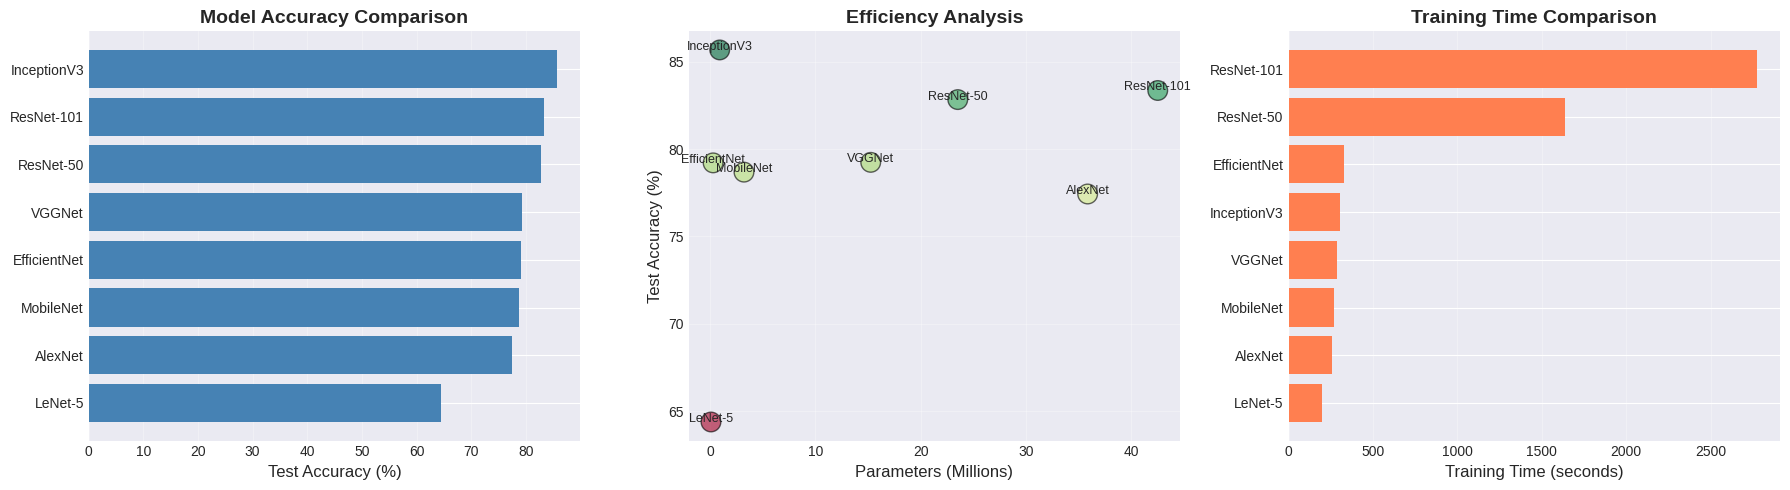

✓ Visualization saved to part1_comparison.png


In [ ]:
if PART1_ENABLED:
    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy comparison
    ax1 = axes[0]
    data_sorted = part1_df.sort_values('Test Accuracy', ascending=True)
    ax1.barh(data_sorted['Model'], data_sorted['Test Accuracy'], color='steelblue')
    ax1.set_xlabel('Test Accuracy (%)', fontsize=12)
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Parameters vs Accuracy
    ax2 = axes[1]
    ax2.scatter(part1_df['Parameters']/1e6, part1_df['Test Accuracy'],
               s=200, c=part1_df['Test Accuracy'], cmap='RdYlGn', alpha=0.6, edgecolors='black')
    for idx, row in part1_df.iterrows():
        ax2.annotate(row['Model'], (row['Parameters']/1e6, row['Test Accuracy']),
                    fontsize=9, ha='center')
    ax2.set_xlabel('Parameters (Millions)', fontsize=12)
    ax2.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax2.set_title('Efficiency Analysis', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    # Training time
    ax3 = axes[2]
    data_time = part1_df.sort_values('Training Time (s)', ascending=True)
    ax3.barh(data_time['Model'], data_time['Training Time (s)'], color='coral')
    ax3.set_xlabel('Training Time (seconds)', fontsize=12)
    ax3.set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('part1_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Visualization saved to part1_comparison.png")

In [ ]:
if PART2_ENABLED:
    print("="*70)
    print("PART 2: LOSS FUNCTION COMPARISON")
    print("="*70)

    part2_results = []
    trained_models = {}

    for model_name, opt_name, epochs, loss_name in PART2_EXPERIMENTS:
        print(f"\n{'='*60}")
        print(f"Experiment: {model_name} + {opt_name} + {loss_name}")
        print(f"{'='*60}")

        # Create base model
        if model_name == 'VGGNet':
            base_model = VGGNet(num_classes, input_channels)
        elif model_name == 'AlexNet':
            base_model = AlexNet(num_classes, input_channels)
        elif model_name == 'ResNet-50':
            base_model = ResNet50(num_classes, input_channels)

        # Setup loss
        use_arcface = loss_name == 'ArcFace'

        if use_arcface:
            model = ArcFaceModel(base_model, num_classes, feature_dim=512).to(device)
            criterion = nn.CrossEntropyLoss()
        else:
            model = base_model.to(device)
            if loss_name == 'Focal':
                criterion = FocalLoss(alpha=1, gamma=2)
            else:  # BCE
                criterion = nn.CrossEntropyLoss()

        # Setup optimizer
        if opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        elif opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Train
        train_losses, train_accs = train_model(model, trainloader, criterion,
                                               optimizer, epochs,
                                               f"{model_name}-{loss_name}", use_arcface)

        # Evaluate
        test_loss, test_acc = evaluate_model(model, testloader, criterion, use_arcface)

        # Store results
        part2_results.append({
            'Model': model_name,
            'Optimizer': opt_name,
            'Epochs': epochs,
            'Loss Function': loss_name,
            'Training Accuracy': train_accs[-1],
            'Testing Accuracy': test_acc
        })

        # Store for Part 3
        trained_models[f"{model_name}-{loss_name}"] = (model, use_arcface)

        print(f"\nResults:")
        print(f"  Training Accuracy: {train_accs[-1]:.2f}%")
        print(f"  Testing Accuracy: {test_acc:.2f}%")

    # Create DataFrame
    part2_df = pd.DataFrame(part2_results)

    print("\n" + "="*70)
    print("PART 2 RESULTS SUMMARY")
    print("="*70)
    display(part2_df)

    if SAVE_RESULTS:
        part2_df.to_csv('part2_results.csv', index=False)
        print("\n✓ Results saved to part2_results.csv")
else:
    print("Part 2 is disabled. Set PART2_ENABLED = True to run.")

PART 2: LOSS FUNCTION COMPARISON

Experiment: VGGNet + Adam + BCE


VGGNet-BCE Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


VGGNet-BCE Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

VGGNet-BCE Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():
^ ^^  ^ ^ 

Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Results:
  Training Accuracy: 80.59%
  Testing Accuracy: 80.52%

Experiment: AlexNet + SGD + Focal


AlexNet-Focal Epoch 1/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>    if w.is_alive():

 Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
       self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     if w.is_alive():^
^ ^^^ ^ ^^ ^ ^ ^^ 
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^^^
^ ^^ ^  ^   
  File "/usr/lib

AlexNet-Focal Epoch 2/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^^self._shutdown_workers()^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    
if w.is_alive():  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process' 
          ^ ^ ^ ^  ^ ^ ^^^^^^^^^^^^^
^  Fi

AlexNet-Focal Epoch 3/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    
    if w.is_alive():Traceback (most recent call last):

self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 
       File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     

AlexNet-Focal Epoch 4/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 5/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 6/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 7/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 8/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 9/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 10/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 11/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>

AlexNet-Focal Epoch 12/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^
^ ^  ^ 
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
     ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^ ^ ^  ^  ^ ^ ^^
  File "/usr/li

AlexNet-Focal Epoch 13/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

AlexNet-Focal Epoch 14/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>

 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^^
^^  ^ ^ ^ ^^ 
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^ ^ ^^ ^ ^ ^
   File "/usr/lib

AlexNet-Focal Epoch 15/20:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()
Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>    if w.is_alive():if w.is_alive():


Traceback (most recent call last):
     File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654

AlexNet-Focal Epoch 16/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 17/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 18/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 19/20:   0%|          | 0/391 [00:00<?, ?it/s]

AlexNet-Focal Epoch 20/20:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]


Results:
  Training Accuracy: 84.76%
  Testing Accuracy: 82.63%

Experiment: ResNet-50 + Adam + ArcFace


ResNet-50-ArcFace Epoch 1/15:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50-ArcFace Epoch 2/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 3/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 4/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 5/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 6/15:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50-ArcFace Epoch 7/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 8/15:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50-ArcFace Epoch 9/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 10/15:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50-ArcFace Epoch 11/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 12/15:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50-ArcFace Epoch 13/15:   0%|          | 0/391 [00:00<?, ?it/s]

ResNet-50-ArcFace Epoch 14/15:   0%|          | 0/391 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

ResNet-50-ArcFace Epoch 15/15:   0%|          | 0/391 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bbf803f63e0>Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
    if w.is_alive():   
^^ ^^ ^ ^ ^  ^^ ^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^^
^^ ^ ^ ^ 
   File "/usr/lib/p


Results:
  Training Accuracy: 10.00%
  Testing Accuracy: 10.00%

PART 2 RESULTS SUMMARY


,Model,Optimizer,Epochs,Loss Function,Training Accuracy,Testing Accuracy
0,VGGNet,Adam,10,BCE,80.588,80.52
1,AlexNet,SGD,20,Focal,84.764,82.63
2,ResNet-50,Adam,15,ArcFace,10.000,10.00



✓ Results saved to part2_results.csv


### Part 2: Visualize Results

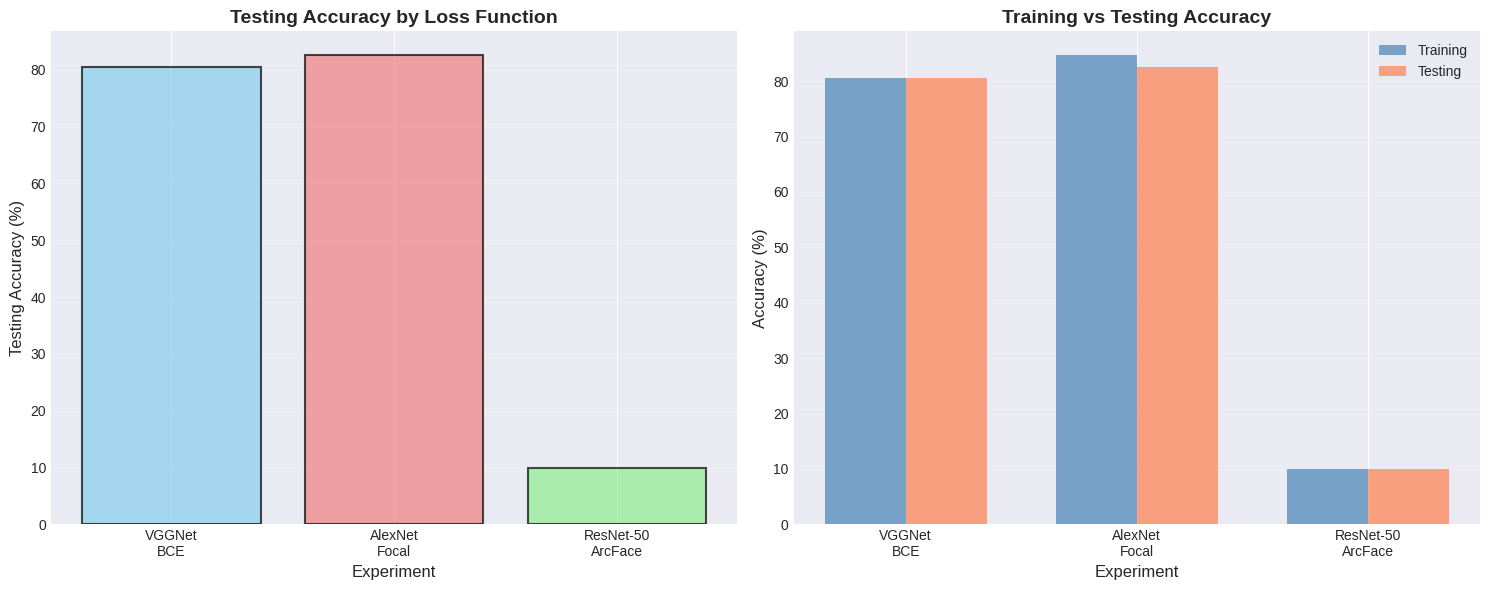

✓ Visualization saved to part2_comparison.png


In [ ]:
if PART2_ENABLED:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy by loss function
    colors = {'BCE': 'skyblue', 'Focal': 'lightcoral', 'ArcFace': 'lightgreen'}
    bar_colors = [colors[loss] for loss in part2_df['Loss Function']]

    x_pos = np.arange(len(part2_df))
    ax1.bar(x_pos, part2_df['Testing Accuracy'], color=bar_colors, alpha=0.7,
            edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Experiment', fontsize=12)
    ax1.set_ylabel('Testing Accuracy (%)', fontsize=12)
    ax1.set_title('Testing Accuracy by Loss Function', fontsize=14, fontweight='bold')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f"{row['Model']}\n{row['Loss Function']}"
                         for _, row in part2_df.iterrows()], rotation=0)
    ax1.grid(axis='y', alpha=0.3)

    # Training vs Testing
    x = np.arange(len(part2_df))
    width = 0.35
    ax2.bar(x - width/2, part2_df['Training Accuracy'], width,
            label='Training', color='steelblue', alpha=0.7)
    ax2.bar(x + width/2, part2_df['Testing Accuracy'], width,
            label='Testing', color='coral', alpha=0.7)
    ax2.set_xlabel('Experiment', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training vs Testing Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f"{row['Model']}\n{row['Loss Function']}"
                         for _, row in part2_df.iterrows()], rotation=0)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('part2_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Visualization saved to part2_comparison.png")

PART 3: FEATURE VISUALIZATION WITH t-SNE

Extracting features for VGGNet-BCE...

Extracting features for AlexNet-Focal...

Extracting features for ResNet-50-ArcFace...

Computing t-SNE projections...
  Computing t-SNE for VGGNet-BCE...
  Computing t-SNE for AlexNet-Focal...
  Computing t-SNE for ResNet-50-ArcFace...


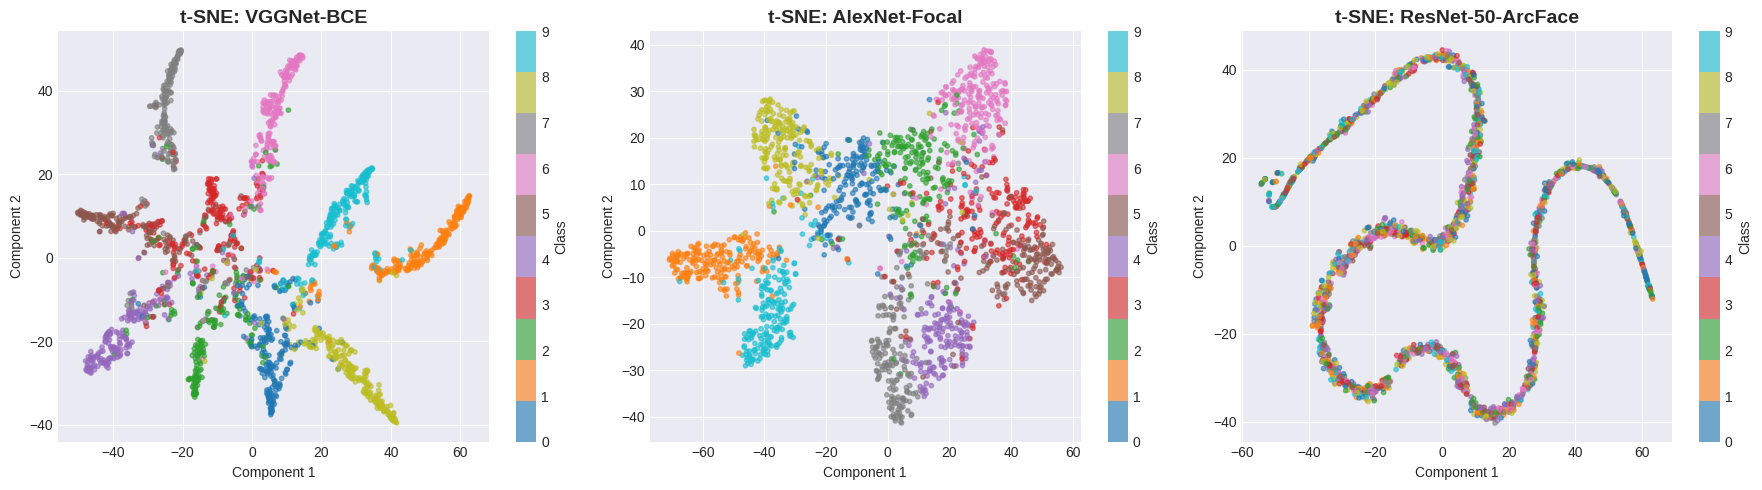


✓ t-SNE visualization saved to part3_tsne.png


In [ ]:
from sklearn.manifold import TSNE
def extract_features_for_tsne(model, dataloader, max_samples=2000, use_arcface=False):
    """Extract features for t-SNE visualization"""
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            if use_arcface:
                # For ArcFace models
                features = model(inputs)
            else:
                # Get the base model
                base_model = model.base_model if hasattr(model, 'base_model') else model

                # Extract features based on model type
                if isinstance(base_model, ResNet):
                    features = base_model.extract_features(inputs)
                elif isinstance(base_model, VGGNet):
                    x = base_model.features(inputs)
                    x = base_model.avgpool(x)
                    features = x.view(x.size(0), -1)
                elif isinstance(base_model, AlexNet):
                    x = base_model.features(inputs)
                    x = base_model.avgpool(x)
                    x = x.view(x.size(0), -1)
                    # Get features before last layer
                    x = base_model.classifier[0](x)  # Dropout
                    x = base_model.classifier[1](x)  # Linear
                    x = base_model.classifier[2](x)  # ReLU
                    x = base_model.classifier[3](x)  # Dropout
                    features = base_model.classifier[4](x)  # Second linear layer
                elif isinstance(base_model, MobileNet):
                    x = base_model.model(inputs)
                    features = x.view(x.size(0), -1)
                else:
                    # Default: use model output
                    features = base_model(inputs)

            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())

            if len(features_list) * inputs.size(0) >= max_samples:
                break

    features = np.concatenate(features_list, axis=0)[:max_samples]
    labels = np.concatenate(labels_list, axis=0)[:max_samples]

    return features, labels


if PART3_ENABLED and PART2_ENABLED:
    print("="*70)
    print("PART 3: FEATURE VISUALIZATION WITH t-SNE")
    print("="*70)

    features_dict = {}

    for name, (model, use_arcface) in trained_models.items():
        print(f"\nExtracting features for {name}...")
        features, labels = extract_features_for_tsne(model, testloader,
                                                     max_samples=TSNE_SAMPLES,
                                                     use_arcface=use_arcface)
        features_dict[name] = features

    # Plot t-SNE
    print("\nComputing t-SNE projections...")
    fig, axes = plt.subplots(1, len(features_dict), figsize=(6*len(features_dict), 5))
    if len(features_dict) == 1:
        axes = [axes]

    for idx, (name, features) in enumerate(features_dict.items()):
        print(f"  Computing t-SNE for {name}...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        features_2d = tsne.fit_transform(features)

        scatter = axes[idx].scatter(features_2d[:, 0], features_2d[:, 1],
                                   c=labels, cmap='tab10', alpha=0.6, s=10)
        axes[idx].set_title(f't-SNE: {name}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Component 1')
        axes[idx].set_ylabel('Component 2')
        plt.colorbar(scatter, ax=axes[idx], label='Class')

    plt.tight_layout()
    plt.savefig('part3_tsne.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n✓ t-SNE visualization saved to part3_tsne.png")

elif PART3_ENABLED and not PART2_ENABLED:
    print("Part 3 requires Part 2 to be enabled first!")
else:
    print("Part 3 is disabled. Set PART3_ENABLED = True to run.")

## Summary and Conclusions

In [ ]:
print("="*70)
print("EXPERIMENT SUMMARY")
print("="*70)

if PART1_ENABLED:
    print("\nPART 1 - Architecture Comparison:")
    best_model = part1_df.loc[part1_df['Test Accuracy'].idxmax()]
    print(f"  Best Model: {best_model['Model']}")
    print(f"  Test Accuracy: {best_model['Test Accuracy']:.2f}%")
    print(f"  Parameters: {best_model['Parameters']:,}")

if PART2_ENABLED:
    print("\nPART 2 - Loss Function Comparison:")
    best_loss = part2_df.loc[part2_df['Testing Accuracy'].idxmax()]
    print(f"  Best Configuration: {best_loss['Model']} + {best_loss['Loss Function']}")
    print(f"  Testing Accuracy: {best_loss['Testing Accuracy']:.2f}%")
    print(f"  Optimizer: {best_loss['Optimizer']}")

if PART3_ENABLED:
    print("\nPART 3 - Feature Visualization:")
    print("  t-SNE plots show feature clustering for different loss functions")
    print("  Better separation indicates better feature discrimination")

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETED!")
print("="*70)

if SAVE_RESULTS:
    print("\nFiles saved:")
    if PART1_ENABLED:
        print("  - part1_results.csv")
        print("  - part1_comparison.png")
    if PART2_ENABLED:
        print("  - part2_results.csv")
        print("  - part2_comparison.png")
    if PART3_ENABLED:
        print("  - part3_tsne.png")

EXPERIMENT SUMMARY

PART 1 - Architecture Comparison:
  Best Model: InceptionV3
  Test Accuracy: 85.67%
  Parameters: 912,298

PART 2 - Loss Function Comparison:
  Best Configuration: AlexNet + Focal
  Testing Accuracy: 82.63%
  Optimizer: SGD

PART 3 - Feature Visualization:
  t-SNE plots show feature clustering for different loss functions
  Better separation indicates better feature discrimination

ALL EXPERIMENTS COMPLETED!

Files saved:
  - part1_results.csv
  - part1_comparison.png
  - part2_results.csv
  - part2_comparison.png
  - part3_tsne.png
